## Plot Benchmark Data
This python notebook uses `matplotlib` and `pandas`.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def readspeed_hist(df, local, fs, process, **kwargs) :
    """Get slice from pandas.DataFrame and plot histogram
    
    Histogram is filled with time / size * 10 ** 6 so that the
    filled variable has units of s / MB. The histogram generated
    is given a label corresponding to the inputs local and fs.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe of data read in during runs
    local : bool
        copied to local scratch run or not?
    fs : str
        'hdfs' or 'zfs' filesystem
    kwargs : dict
        passed on to plt.hist
    """
    sl = df[(df['local'] == local) & (df['filesystem'] == fs)]
    local_str = 'remote read'
    if local :
        local_str = 'cp to scratch then read'
    data = pd.to_numeric(sl['size'])/pd.to_numeric(sl['time'])/10**6
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, label = f'{fs} {local_str}', histtype='step', **kwargs)
    
def readspeed_comp(df,title, **kwargs) :
    """Generate a comparison plot from the input file
    
    Four histograms are put onto the plot using the hist
    function above - they involve all four combinations
    of the two local options (True/False) and the two filesystem
    options ('hdfs'/'zfs').
    
    Parameters
    ----------
    df : str or pandas.DataFrame
        Filename with data to read from
    title : str, optional
        Title to add to plot, use filename by default
    kwargs : dict
        Passed on to hist
    """
    
    if isinstance(df,str) :
        df = pd.read_csv(df)
        df.dropna()
        
    readspeed_hist(df, True , 'hdfs', True, ls='--', ec='steelblue', **kwargs)
    readspeed_hist(df, False, 'hdfs', True, ls='-' , ec='steelblue', **kwargs)
    readspeed_hist(df, True , 'zfs' , True, ls='--', ec='salmon'   , **kwargs)
    readspeed_hist(df, False, 'zfs' , True, ls='-' , ec='salmon'   , **kwargs)
    plt.xlabel('Read Speed [MBps]',size='xx-large')
    plt.ylabel('Fraction of Jobs',size='xx-large')
    plt.yscale('log')
    plt.title(title,size='xx-large')
    plt.legend()
    return df

def time_hist(df, local, fs, process, **kwargs) :
    """Get slice from pandas.DataFrame and plot histogram
    
    Histogram is filled with time / size * 10 ** 6 so that the
    filled variable has units of s / MB. The histogram generated
    is given a label corresponding to the inputs local and fs.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe of data read in during runs
    local : bool
        copied to local scratch run or not?
    fs : str
        'hdfs' or 'zfs' filesystem
    kwargs : dict
        passed on to plt.hist
    """
    sl = df[(df['local'] == local) & (df['filesystem'] == fs)]
    local_str = 'remote read'
    if local :
        local_str = 'cp to scratch then read'
    data = pd.to_numeric(sl['time']) / pd.to_numeric(sl['size']) * 1e9 # scale time to 1GB file
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, label = f'{fs} {local_str}', histtype='step', **kwargs)
    
def time_comp(df,title, **kwargs) :
    """Generate a comparison plot from the input file
    
    Four histograms are put onto the plot using the hist
    function above - they involve all four combinations
    of the two local options (True/False) and the two filesystem
    options ('hdfs'/'zfs').
    
    Parameters
    ----------
    df : str or pandas.DataFrame
        Filename with data to read from
    title : str, optional
        Title to add to plot, use filename by default
    kwargs : dict
        Passed on to hist
    """
    
    if isinstance(df,str) :
        df = pd.read_csv(df)
        df.dropna()
        df.to_numeric()
    
    time_hist(df, True , 'hdfs', True, ls='--', ec='steelblue', **kwargs)
    time_hist(df, False, 'hdfs', True, ls='-' , ec='steelblue', **kwargs)
    time_hist(df, True , 'zfs' , True, ls='--', ec='salmon'   , **kwargs)
    time_hist(df, False, 'zfs' , True, ls='-' , ec='salmon'   , **kwargs)
    plt.xlabel('Equivalent Job Time for 1GB File [s]',size='xx-large')
    plt.ylabel('Fraction of Jobs',size='xx-large')
    plt.yscale('log')
    plt.title(title,size='xx-large')
    plt.legend()
    return df

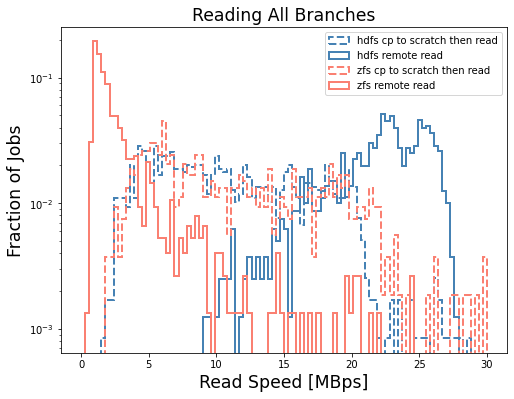

In [5]:
plt.figure(figsize=(8,6))
df = readspeed_comp('all-branches.csv','Reading All Branches', bins=100,range=(0.,30.),lw=2.)
plt.show()

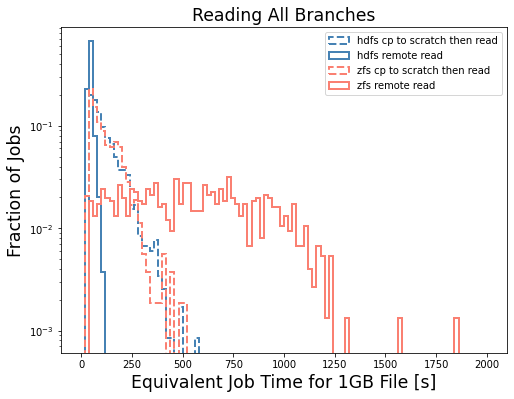

In [7]:
plt.figure(figsize=(8,6))
df = time_comp(df,'Reading All Branches', bins=100,range=(0.,2000.),lw=2.)
plt.show()

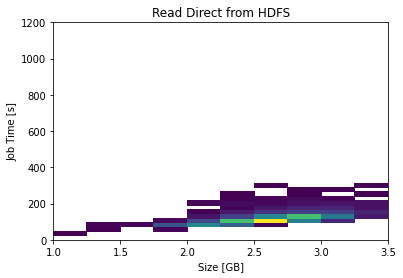

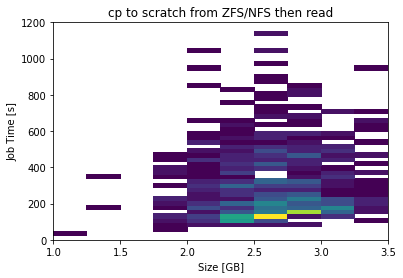

In [18]:
sl = df[(df['local']==False)&(df['filesystem']=='hdfs')]
plt.hist2d(sl['size']/1e9,sl['time'], cmin = 1, bins=(10,50), range=((1.,3.5),(0.,1200.)))
plt.xlabel('Size [GB]')
plt.ylabel('Job Time [s]')
plt.title('Read Direct from HDFS')
plt.show()
sl = df[(df['local']==True)&(df['filesystem']=='zfs')]
plt.hist2d(sl['size']/1e9,sl['time'], cmin = 1, bins=(10,50), range=((1.,3.5),(0.,1200.)))
plt.xlabel('Size [GB]')
plt.ylabel('Job Time [s]')
plt.title('cp to scratch from ZFS/NFS then read')
plt.show()

In [21]:
# assuming df is still all-branches df
max_hdfs_time = max(df[(df['filesystem']=='hdfs')&(df['local']==False)]['time'])
len(df[(df['filesystem']=='zfs')&(df['local']==True)&(df['time']>max_hdfs_time)]['time'])

224

# Don't Trust Plot Below
Can't get aligning to work to compare the same file between the two runs.

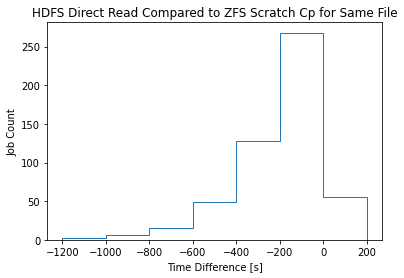

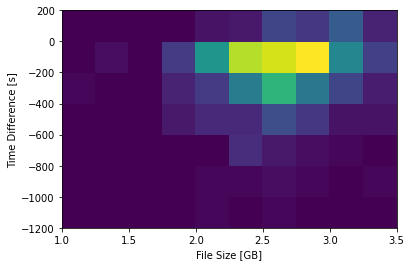

In [54]:
# pull out filesystem data frames and filter for files that succeeded in both runs
hdfs_df = df[(df['filesystem']=='hdfs')&(df['local']==False)]
zfs_df = df[(df['filesystem']=='zfs')&(df['local']==True)]
hdfs_df = hdfs_df.loc[hdfs_df['size'].isin(zfs_df['size'])]
zfs_df = zfs_df.loc[zfs_df['size'].isin(hdfs_df['size'])]
hdfs_df.sort_values(by=['size'])
zfs_df.sort_values(by=['size'])

# plot time difference
time_diff = hdfs_df['time'].to_numpy()-zfs_df['time'].to_numpy()
plt.hist(time_diff, bins=7,range=(-1200,200), histtype='step')
plt.xlabel('Time Difference [s]')
plt.ylabel('Job Count')
plt.title('HDFS Direct Read Compared to ZFS Scratch Cp for Same File')
plt.show()

plt.hist2d(hdfs_df['size']/1e9,time_diff,bins=(10,7),range=((1.,3.5),(-1200,200)))
plt.xlabel('File Size [GB]')
plt.ylabel('Time Difference [s]')
plt.show()

## Qualitative Notes
- HDFS remote read is only slightly faster (in time) compared to ZFS cp to scratch then read
- HDFS jobs fail much more regularly due to ROOT's inability to open the file on HDFS, resubmission seems to fix the issue but is annoying for the user
- Copying output files to HDFS also fails more regularly and requires the user to implement a [a special copying function](https://github.com/UMN-CMS/ldmx-scripts/blob/4f7b2f532beea31533b5cf77084974f3bfe56694/batch/run_ldmx.sh#L63-L116) which performs multiple copy attempts and checks that the full file was actually copied

# Subset of Branches
For a more realistic analysis of analysis jobs, the user expects to only read a subset of the branches available. A reasonable upper limit for the number of branches accessed in a given analysis job is about 50 (out of the hundreds of branches available), so I chose to just choose that nice round number.

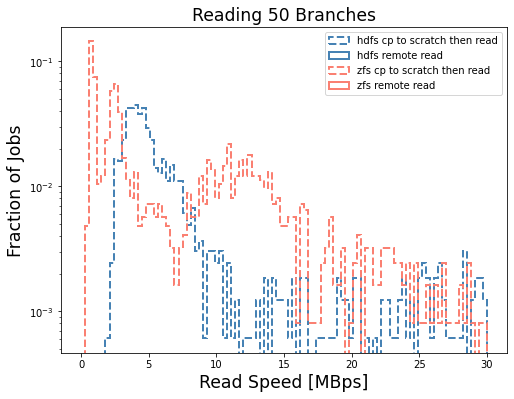

In [18]:
plt.figure(figsize=(8,6))
df = readspeed_comp('50-branches.csv','Reading 50 Branches',bins=100,range=(0.,30.),lw=2.)
plt.show()

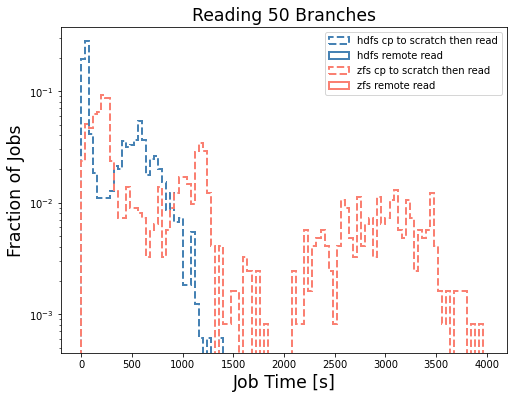

In [19]:
plt.figure(figsize=(8,6))
df = time_comp(df,'Reading 50 Branches', bins=100,range=(0.,4000.),lw=2.)
plt.show()

## No Processing Runs
The runs below are for just performing the copy to scratch and then skipping any processing of the file. This is a good test of the fastest the copy-to-scratch style analyses can be. I haven't been able to verify that what I think is happening is actualy happening, so the plots below are **extremely preliminary** and may change drastically with future runs.

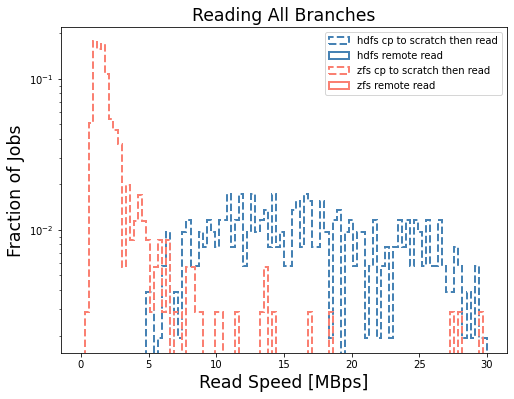

In [4]:
plt.figure(figsize=(8,6))
df = readspeed_comp('no-process.csv','Reading All Branches', bins=100,range=(0.,30.),lw=2.)
plt.show()

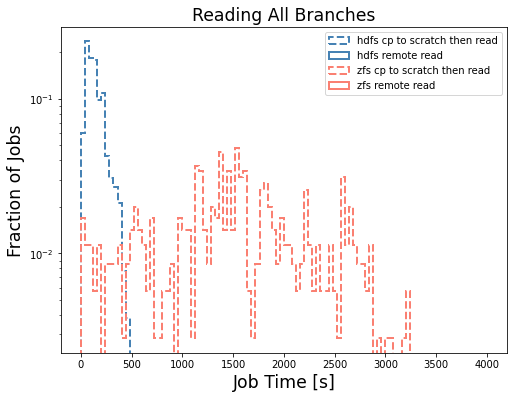

In [5]:
plt.figure(figsize=(8,6))
df = time_comp(df,'Reading All Branches', bins=100,range=(0.,4000.),lw=2.)
plt.show()